# Solving A transverse field Ising model

In [3]:
using Yao
using Statistics: mean
using LinearAlgebra
using Plots

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/jcode/ssss/Project.toml`
 [no changes]
  Updating `~/jcode/ssss/Manifest.toml`
 [no changes]


In [2]:
print(Measure(5; locs=AllLocs()))

Measure{5,5,ComputationalBasis}

## Model Hamiltonians

### Transverse field Ising Model

$H = \sum\limits_{i=1}^{N-1} s_i^z s^z_{i+1} + h\sum\limits^{N}_{i=1} s_i^x$

where $s^\alpha = \frac 1 2 \sigma^\alpha$ is the spin operator.

In [2]:
"""
for simplicity, we require an AbstractModel contains `size` and `periodic` members.
"""
abstract type AbstractModel{D} end

nspin(model::AbstractModel) = prod(model.size)

nspin (generic function with 1 method)

In [3]:
"""
transverse field ising model, `h` is the strength of transverse field.
"""
struct TFI{D} <:AbstractModel{1}
    size::NTuple{D, Int}
    h::Float64
    periodic::Bool
    TFI(size::Int...; h::Real, periodic::Bool) = new{length(size)}(size, Float64(h), periodic)
end

TFI

In [4]:
function get_bonds(model::AbstractModel{1})
    nbit, = model.size
    [(i, i%nbit+1) for i in 1:(model.periodic ? nbit : nbit-1)]
end

function get_bonds(model::AbstractModel{2})
    m, n = model.size
    cis = LinearIndices(model.size)
    bonds = Tuple{Int, Int, Float64}[]
    for i=1:m, j=1:n
        (i!=m || model.periodic) && push!(bonds, (cis[i,j], cis[i%m+1,j]))
        (j!=n || model.periodic) && push!(bonds, (cis[i,j], cis[i,j%n+1]))
    end
    bonds
end

get_bonds (generic function with 2 methods)

In [5]:
function hamiltonian(model::TFI{1})
    nbit = nspin(model)
    sum(repeat(nbit, Z, (i,j)) for (i,j) in get_bonds(model))*0.25 +
    sum(put(nbit, i=>X) for i=1:nbit)*0.5model.h
end

hamiltonian (generic function with 1 method)

In [6]:
tfi_model = TFI(4; h=0.5, periodic=false)

TFI{1}((4,), 0.5, false)

In [7]:
tfi_h = hamiltonian(tfi_model)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.25] sum
│     ├─ repeat on (1, 2)
│     │  └─ Z gate
│     ├─ repeat on (2, 3)
│     │  └─ Z gate
│     └─ repeat on (3, 4)
│        └─ Z gate
└─ [scale: 0.25] sum
      ├─ put on (1)
      │  └─ X gate
      ├─ put on (2)
      │  └─ X gate
      ├─ put on (3)
      │  └─ X gate
      └─ put on (4)
         └─ X gate


# A quantum circuit as an ansatz

Construct the following circuit as our ansatz

<div style="display:inline-block"><img style="float:left", src="images/fourqubit.png" width="500"></div>

In [8]:
function ansatz_circuit(nbit::Int, d::Int)
    circuit = chain(nbit)
    
    Rxz = chain(Rx(0.0), Rz(0.0))

    for i=1:nbit-1
        unit = chain(nbit)
        for j=1:d
            push!(unit, put(nbit, i=>Rxz))
            push!(unit, put(nbit, nbit=>Rxz))
            push!(unit, control(nbit, 1, 2=>shift(0.0)))
        end
        push!(circuit, unit)
    end
    for i=1:nbit
        push!(circuit, Measure{nbit, 1, AbstractBlock}(Z, (i,), 0, false))
    end
    circuit
end

ansatz_circuit (generic function with 1 method)

In [9]:
circuit = ansatz_circuit(4, 1)

nqubits: 4, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (4)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  └─ control(1)
│     └─ (2,) shift(0.0)
├─ chain
│  ├─ put on (2)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (4)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  └─ control(1)
│     └─ (2,) shift(0.0)
├─ chain
│  ├─ put on (3)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  ├─ put on (4)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.0)
│  │     └─ rot(Z gate, 0.0)
│  └─ control(1)
│     └─ (2,) shift(0.0)
├─ Measure{4,1,AbstractBlock}
├─ Measure{4,1,AbstractBlock}
├─ Measure{4,1,AbstractBlock}
└─ Measure{4,1,AbstractBlock}

In [10]:
nparameters(circuit)

15

In [71]:
"""
    gensample(circuit, operator; nbatch=1024) -> Vector of Measure

Generate samples from MPS-inspired circuit. Here, `nbatch` means nshot.
`operator` is the operator to measure.
This function returns a vector of `Measure` gates, results are stored in `m.results`.
"""
function gensample(circuit, operator; nbatch=1024)
    mblocks = collect_blocks(Measure, circuit)
    for m in mblocks
        m.operator = operator
    end
    reg = zero_state(nqubits(circuit); nbatch=nbatch)
    reg |> circuit
    mblocks
end

gensample

In [72]:
res = gensample(circuit, X; nbatch=1024)

4-element Array{Measure,1}:
 Measure{4,1,AbstractBlock}
 Measure{4,1,AbstractBlock}
 Measure{4,1,AbstractBlock}
 Measure{4,1,AbstractBlock}

In [73]:
res[1].results

1024-element Array{Int64,1}:
  1
 -1
  1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  1
  1
  1
  ⋮
  1
  1
  1
  1
  1
  1
  1
  1
 -1
 -1
 -1
  1

Get the energy through sampling

In [74]:
function ising_energy(circuit, bonds, basis; nbatch=nbatch)
    mblocks = gensample(circuit, basis; nbatch=nbatch)
    nspin = length(mblocks)
    local eng = 0.0
    for (a, b) in bonds
        eng += mean(mblocks[a].results .* mblocks[b].results)
    end
    eng/=4
end

function energy(circuit, model::TFI; nbatch=1024)
    # measuring Z
    eng = ising_energy(circuit, get_bonds(model), Z; nbatch=nbatch)
    # measuring X
    mblocks = gensample(circuit, X; nbatch=nbatch)
    engx = sum(mean.([m.results for m in mblocks]))
    eng + model.h*engx/2
end

energy (generic function with 1 method)

In [75]:
# obtain the energy through sampling
energy(circuit, tfi_model; nbatch=10000)

0.75195

In [76]:
wave_function(circuit) = zero_state(nqubits(circuit)) |> circuit

wave_function (generic function with 1 method)

In [77]:
# obtain the exact <H> through wave function
energy_exact(circuit, model; args...) = expect(hamiltonian(model), wave_function(circuit)) |> real
energy_exact(circuit, tfi_model)

0.75

## Obtaining the ground state

Sequential optimization
1. obtain the gradient of one parameter a time $\frac{\partial E_\theta}{\partial \theta} = \frac 1 2 (E_{\theta+\pi/2}-E_{\theta-\pi/2})$
2. perform gradient descent update of this parameter $\theta\rightarrow \theta-\alpha \frac{\partial E_\theta}{\partial \theta}$
3. sweep all parameters until convergence.

In [78]:
fidelity(psi, VG) = abs(psi' * VG)

fidelity (generic function with 1 method)

In [79]:
nparameters(circuit)

15

In [80]:
using Flux: ADAM, Optimise
include("lib/Adam.jl")

gclip! (generic function with 1 method)

In [87]:
function train!(circuit, model; VG=nothing, maxiter=200, α=0.3, nbatch=1024)
    rots = collect_blocks(Union{RotationGate, ControlBlock{<:Any, <:ShiftGate}}, circuit)
    loss_history = Float64[]
    params = parameters(circuit)
    grad = zero(params)
    optimizer = ADAM(α)
    for i in 0:maxiter
        for (j,r) in enumerate(rots)
            dispatch!(+, r, (π/2,))
            E₊ = energy_exact(circuit, model; nbatch=nbatch)
            dispatch!(-, r, (π,))
            E₋ = energy_exact(circuit, model; nbatch=nbatch)
            dispatch!(+, r, (π/2,))
            g = 0.5(E₊ - E₋)
            grad[j] = g
        end
        Optimise.update!(optimizer, params, grad)
        #update!(params, grad, optimizer)
        dispatch!.(rots, params)
        push!(loss_history, energy_exact(circuit, model, nbatch=nbatch)/nspin(model))
        
        if i%1 == 0
            println("Iter $i, E/N = $(loss_history[end])")
        end
    end
    loss_history, circuit
end

train! (generic function with 1 method)

In [88]:
lattice_size = 4
circuit = ansatz_circuit(lattice_size, 3)
model = TFI(lattice_size; h=0.5, periodic=false)
h = hamiltonian(model)

nqubits: 4, datatype: Complex{Float64}
sum
├─ [scale: 0.25] sum
│     ├─ repeat on (1, 2)
│     │  └─ Z gate
│     ├─ repeat on (2, 3)
│     │  └─ Z gate
│     └─ repeat on (3, 4)
│        └─ Z gate
└─ [scale: 0.25] sum
      ├─ put on (1)
      │  └─ X gate
      ├─ put on (2)
      │  └─ X gate
      ├─ put on (3)
      │  └─ X gate
      └─ put on (4)
         └─ X gate


In [89]:
# obtain the exact ground state energy
res = eigen(mat(h) |> Matrix)
EG = res.values[1]/nspin(model)
@show EG
VG = res.vectors[:,1];

EG = -0.29742315519647605


In [90]:
nparameters(circuit)

45

In [91]:
dispatch!(circuit, :random)
loss_history, circuit = train!(circuit, model; maxiter=100, VG=VG, α=0.3);

Iter 0, E/N = 0.1875
Iter 1, E/N = 0.1875
Iter 2, E/N = 0.1875
Iter 3, E/N = 0.1875
Iter 4, E/N = 0.1875
Iter 5, E/N = 0.1875
Iter 6, E/N = 0.1875
Iter 7, E/N = 0.1875
Iter 8, E/N = 0.18750000000000006
Iter 9, E/N = 0.18749999999999994
Iter 10, E/N = 0.18749999999999994
Iter 11, E/N = 0.1875
Iter 12, E/N = 0.1875
Iter 13, E/N = 0.1875
Iter 14, E/N = 0.1875
Iter 15, E/N = 0.1875
Iter 16, E/N = 0.1875
Iter 17, E/N = 0.1875
Iter 18, E/N = 0.1875
Iter 19, E/N = 0.18750000000000006
Iter 20, E/N = 0.1875
Iter 21, E/N = 0.18749999999999994
Iter 22, E/N = 0.1875
Iter 23, E/N = 0.18750000000000006
Iter 24, E/N = 0.18749999999999997
Iter 25, E/N = 0.18750000000000006
Iter 26, E/N = 0.1875
Iter 27, E/N = 0.18749999999999997
Iter 28, E/N = 0.1875
Iter 29, E/N = 0.1875
Iter 30, E/N = 0.1875
Iter 31, E/N = 0.1875
Iter 32, E/N = 0.1875
Iter 33, E/N = 0.18749999999999994
Iter 34, E/N = 0.1875
Iter 35, E/N = 0.1875
Iter 36, E/N = 0.18749999999999997
Iter 37, E/N = 0.18749999999999994
Iter 38, E/N = 0.1

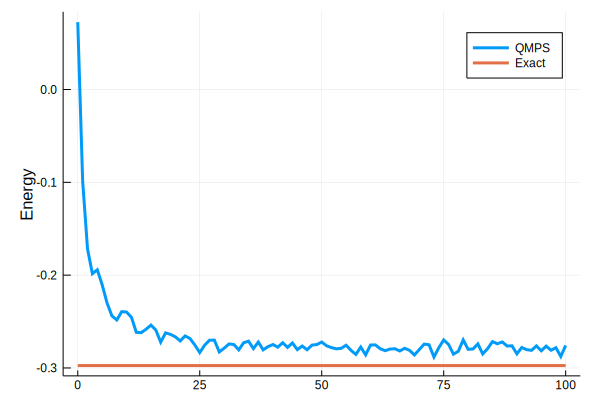

In [422]:
M = length(loss_history)
plot(0:M-1, [loss_history, fill(EG, M)], label=["QMPS", "Exact"], lw=3, ylabel="Energy")

In [423]:
circuit

nqubits: 2, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.07704615078670439)
│  │     └─ rot(Z gate, 1.9126587963726118)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 1.1683729798815674)
│  ├─ control(1)
│  │  └─ (2,)shift(-0.035768834905253795)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 2.1742560988798867)
│  │     └─ rot(Z gate, -1.6010494730477072)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, -1.4841550361270974)
│  └─ Measure{2,1,AbstractBlock}
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, -0.3877006786799756)
│  │     └─ rot(Z gate, -0.9338857822255419)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 2.182783352938954)
│  ├─ control(1)
│  │  └─ (2,)shift(0.25304518656007163)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.9082957458769617)
│  │     └─ rot(Z gate, -1.9420436979852698)
│  ├─ put on (2)
│  │  └─ H ga

In [424]:
parameters(circuit)

21-element Array{Float64,1}:
  0.07704615078670439 
  1.9126587963726118  
  1.1683729798815674  
 -0.035768834905253795
  2.1742560988798867  
 -1.6010494730477072  
 -1.4841550361270974  
 -0.3877006786799756  
 -0.9338857822255419  
  2.182783352938954   
  0.25304518656007163 
  0.9082957458769617  
 -1.9420436979852698  
 -0.8952920962789711  
  0.7960753051963408  
  0.19729551473047033 
  2.684665952673796   
 -0.9983654336840248  
  1.9258925449011384  
 -0.7526389104264475  
 -0.37239572353900163 

## Build a quantum circuit inspired by MPS

Hadamard Gate with dashed box is applied only when measuring on the X basis.
<div style="display:inline-block"><img style="float: left", src="images/hgate.png" width="50"/></div>

The following gates Measure and Reset a qubit to 0.

<div style="display:inline-block"><img style="float:left", src="images/mreset.png" width="100"></div>

The goal of this section is to build the MPS-inspired sampler as our ansatz

<div style="display:inline-block"><img style="float:left", src="images/twoqubit.png"></div>

### Reference: Variational Quantum Eigensolver with Fewer Qubits

*Jin-Guo Liu, Yi-Hong Zhang, Yuan Wan, Lei Wang*

https://arxiv.org/abs/1902.02663

In [369]:
rotor(noleading::Bool=false, notrailing::Bool=false) = noleading ? (notrailing ? Rx(0) : chain(Rx(0), Rz(0))) : (notrailing ? chain(Rz(0), Rx(0)) : chain(Rz(0), Rx(0), Rz(0)))

"""
    ansatz_circuit(nlayer::Int, nrepeat::Int)

Construct the above ansatz, `nrepeat` is the number of measure operations,
`nlayer` is the length of each block.
"""
function ansatz_circuit(nlayer::Int, nrepeat::Int)
    nbit_measure = nbit_virtual = 1
    nbit_used = nbit_measure + nbit_virtual
    circuit = chain(nbit_used)

    for i=1:nrepeat
        unit = chain(nbit_used)
        #push!(unit, put(nbit_used, 2=>H))
        for j=1:nlayer
            push!(unit, put(nbit_used, 1=>rotor(true, false)))
            push!(unit, put(nbit_used, 2=>H))
            push!(unit, put(nbit_used, 2=>Rz(0.0)))
            push!(unit, control(nbit_used, 1, 2=>shift(0.0)))
            if j == nlayer
                push!(unit, put(nbit_used, 1=>rotor(true, false)))
                push!(unit, put(nbit_used, 2=>H))
                push!(unit, put(nbit_used, 2=>Rz(0.0)))
            end
        end
        push!(unit, Measure{nbit_used, 1, AbstractBlock}(Z, (1,), 0, false))
        if i==nrepeat
            for k=2:nbit_used
                push!(unit, Measure{nbit_used, 1, AbstractBlock}(Z, (k,), 0, false))
            end
        end
        push!(circuit, unit)
    end
    dispatch!(circuit, :random)
end

twoqubit_circuit

In [370]:
circuit = ansatz_circuit(1, 3)

nqubits: 2, datatype: Complex{Float64}
chain
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.21095863334236697)
│  │     └─ rot(Z gate, 0.7061513298045752)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.606758675085191)
│  ├─ control(1)
│  │  └─ (2,)shift(0.8692942974976297)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.9742930709729192)
│  │     └─ rot(Z gate, 0.2511950574828521)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.8950395744932531)
│  └─ Measure{2,1,AbstractBlock}
├─ chain
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.8280959771285328)
│  │     └─ rot(Z gate, 0.6397794287466416)
│  ├─ put on (2)
│  │  └─ H gate
│  ├─ put on (2)
│  │  └─ rot(Z gate, 0.43658892015653006)
│  ├─ control(1)
│  │  └─ (2,)shift(0.22277943843476922)
│  ├─ put on (1)
│  │  └─ chain
│  │     ├─ rot(X gate, 0.6583878015555824)
│  │     └─ rot(Z gate, 0.054800922397594265)
│  ├─ put on (2)
│  │  └─ H gate
│ 